In [1]:
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
def standart_scaler(col_name):
    return (col_name - col_name.mean()) / col_name.std()

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):

    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in df.columns if
                   df[col].nunique() > car_th and str(df[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
gss = pd.read_csv("gss_data.csv")

df = gss.loc[:, ["caseid", "year", "age", "sex", "race", "degree", "marital", "childs", "polviews", "natenvir", "confed", "conarmy", "conjudge", "class", "abany", "helppoor", "helpsick", "helpblk"]]

C:\Users\psyen\AppData\Local\Temp/ipykernel_10048/335361090.py:1: DtypeWarning: Columns (6,7,13,26,44,45,46,47,65,66,67,68,69,76,77,80,81,89,93) have mixed types. Specify dtype option on import or set low_memory=False.
  gss = pd.read_csv("gss_data.csv")


In [5]:
df.columns = [x.upper() for x in df.columns]

In [6]:
df = df.loc[df["YEAR"] >= 2008, :]

In [7]:
df = df.loc[df["POLVIEWS"].notna(), :]

In [8]:
"""le = LabelEncoder()
df["POLVIEWS"] = le.fit_transform(df["POLVIEWS"])"""

df.loc[df["POLVIEWS"] == "Extremely Liberal", "POLVIEWS"] = "1"
df.loc[df["POLVIEWS"] == "Liberal", "POLVIEWS"] = "2"
df.loc[df["POLVIEWS"] == "Slightly Liberal", "POLVIEWS"] = "3"
df.loc[df["POLVIEWS"] == "Moderate", "POLVIEWS"] = "4"
df.loc[df["POLVIEWS"] == "Slightly Conservative", "POLVIEWS"] = "5"
df.loc[df["POLVIEWS"] == "Conservative", "POLVIEWS"] = "6"
df.loc[df["POLVIEWS"] == "Extrmly Conservative", "POLVIEWS"] = "7"
df["POLVIEWS"] = df["POLVIEWS"].astype(int)

In [9]:
##  CONFIDENCE IN INSITUTIONS
conf_govt = [col for col in df.columns if "CON" in col]

for col in conf_govt:
    df[col].fillna("DK", inplace=True)

In [10]:
##  NATIONAL PROBLEMS — environment
nat = [col for col in df.columns if "NAT" in col]

for col in nat:
    df[col].fillna("DK", inplace=True)


In [11]:
##  ABORTION
abor = [col for col in df.columns if "AB" in col and col not in conf_govt and nat]

for col in abor:
    df[col].fillna("DK", inplace=True)

In [12]:
##  SHOULD GOVT HELP
hlp = [col for col in df.columns if "HELP" in col]

for col in hlp:
    df[col].fillna("DK", inplace=True)

In [13]:
missing_values_table(df)

         n_miss  ratio
CLASS        34  0.590
DEGREE       28  0.480
AGE          17  0.290
MARITAL       4  0.070
CHILDS        4  0.070


In [14]:
df.dropna(inplace=True)

In [15]:
df["CHILDS"] = df["CHILDS"].astype(int)
df["AGE"] = df["AGE"].astype(int)
df.loc[df["RACE"] != "White", "RACE"] = "Other"

In [16]:
df["IS_LEFT"] = df["POLVIEWS"]
df.loc[df["POLVIEWS"] < 4, "IS_LEFT"] = "1"
df.loc[df["POLVIEWS"] >= 4, "IS_LEFT"] = "0"
df["IS_LEFT"] = df["IS_LEFT"].astype(int)

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 5696
Variables: 19
cat_cols: 16
num_cols: 1
cat_but_car: 0
num_but_cat: 3


In [18]:
for col in num_cols:
    target_summary_with_num(df, "POLVIEWS", col)

            AGE
POLVIEWS       
1        47.421
2        45.804
3        45.005
4        47.147
5        48.431
6        51.403
7        52.227




In [19]:
for col in cat_cols:
    target_summary_with_cat(df, "POLVIEWS", col)

        TARGET_MEAN
SEX                
Female        4.020
Male          4.160


       TARGET_MEAN
RACE              
Other        3.820
White        4.163


                TARGET_MEAN
DEGREE                     
Bachelor              4.070
Graduate              3.693
High School           4.150
Junior College        4.234
Lt High School        4.068


               TARGET_MEAN
MARITAL                   
Divorced             4.009
Married              4.308
Never Married        3.721
Separated            3.978
Widowed              4.189


             TARGET_MEAN
NATENVIR                
About Right        4.331
DK                 4.113
Too Little         3.758
Too Much           4.976


              TARGET_MEAN
CONFED                   
A Great Deal        3.635
DK                  4.099
Hardly Any          4.270
Only Some           4.046


              TARGET_MEAN
CONARMY                  
A Great Deal        4.328
DK                  4.086
Hardly Any          3.414
Only Some  

In [20]:
for col in cat_cols:
    cat_summary(df, col)

         SEX  Ratio
Female  3133 55.004
Male    2563 44.996
##########################################
       RACE  Ratio
White  4365 76.633
Other  1331 23.367
##########################################
                DEGREE  Ratio
High School       2839 49.842
Bachelor          1053 18.487
Lt High School     750 13.167
Graduate           605 10.621
Junior College     449  7.883
##########################################
               MARITAL  Ratio
Married           2628 46.138
Never Married     1539 27.019
Divorced           885 15.537
Widowed            461  8.093
Separated          183  3.213
##########################################
             NATENVIR  Ratio
DK               2924 51.334
Too Little       1688 29.635
About Right       789 13.852
Too Much          295  5.179
##########################################
              CONFED  Ratio
DK              1915 33.620
Only Some       1795 31.513
Hardly Any      1455 25.544
A Great Deal     531  9.322
#######################

In [21]:
for col in df.columns:
    if "HELP" in col:
        df.loc[df[col] == "DK", col] = "Agree With Both"
    elif "CON" in col:
        df.loc[df[col] == "DK", col] = "Only Some"
    elif "ENVIR" in col:
        df.loc[df[col] == "DK", col] = "About Right"
    else:
        continue

In [22]:
##  Liberal Score  ## (Min-Max Scaling would give the same)

df["HELPPOOR_FLAG"] = df["HELPPOOR"]
df.loc[df["HELPPOOR_FLAG"] == "Agree With Both", "HELPPOOR_FLAG"] = "4"
df.loc[df["HELPPOOR_FLAG"] == "Govt Action", "HELPPOOR_FLAG"] = "7"
df.loc[df["HELPPOOR_FLAG"] == "People Help Selves", "HELPPOOR_FLAG"] = "1"
df["HELPPOOR_FLAG"] = df["HELPPOOR_FLAG"].astype(int)

df["HELPSICK_FLAG"] = df["HELPSICK"]
df.loc[df["HELPSICK_FLAG"] == "Agree With Both", "HELPSICK_FLAG"] = "4"
df.loc[df["HELPSICK_FLAG"] == "Govt Should Help", "HELPSICK_FLAG"] = "7"
df.loc[df["HELPSICK_FLAG"] == "People Help Selves", "HELPSICK_FLAG"] = "1"
df["HELPSICK_FLAG"] = df["HELPSICK_FLAG"].astype(int)

df["HELPBLK_FLAG"] = df["HELPBLK"]
df.loc[df["HELPBLK_FLAG"] == "Agree With Both", "HELPBLK_FLAG"] = "4"
df.loc[df["HELPBLK_FLAG"] == "Govt Help Blks", "HELPBLK_FLAG"] = "7"
df.loc[df["HELPBLK_FLAG"] == "No Special Treatment", "HELPBLK_FLAG"] = "1"
df["HELPBLK_FLAG"] = df["HELPBLK_FLAG"].astype(int)

df["ABANY_FLAG"] = df["ABANY"]
df.loc[df["ABANY_FLAG"] == "DK", "ABANY_FLAG"] = "4"
df.loc[df["ABANY_FLAG"] == "Yes", "ABANY_FLAG"] = "7"
df.loc[df["ABANY_FLAG"] == "No", "ABANY_FLAG"] = "1"
df["ABANY_FLAG"] = df["ABANY_FLAG"].astype(int)

df["NATENVIR_FLAG"] = df["NATENVIR"]
df.loc[df["NATENVIR_FLAG"] == "About Right", "NATENVIR_FLAG"] = "4"
df.loc[df["NATENVIR_FLAG"] == "Too Much", "NATENVIR_FLAG"] = "7"
df.loc[df["NATENVIR_FLAG"] == "Too Little", "NATENVIR_FLAG"] = "1"
df["NATENVIR_FLAG"] = df["NATENVIR_FLAG"].astype(int)

df["LIB_SCORE"] = df["ABANY_FLAG"] + df["NATENVIR_FLAG"] + df["HELPBLK_FLAG"] + df["HELPSICK_FLAG"] + df["HELPPOOR_FLAG"]

In [23]:
##  Confidence in Institutions  ##
df["CONFED_FLAG"] = df["CONFED"]
df.loc[df["CONFED_FLAG"] == "Only Some", "CONFED_FLAG"] = "4"
df.loc[df["CONFED_FLAG"] == "Hardly Any", "CONFED_FLAG"] = "1"
df.loc[df["CONFED_FLAG"] == "A Great Deal", "CONFED_FLAG"] = "7"
df["CONFED_FLAG"] = df["CONFED_FLAG"].astype(int)

df["CONARMY_FLAG"] = df["CONARMY"]
df.loc[df["CONARMY_FLAG"] == "Only Some", "CONARMY_FLAG"] = "4"
df.loc[df["CONARMY_FLAG"] == "Hardly Any", "CONARMY_FLAG"] = "1"
df.loc[df["CONARMY_FLAG"] == "A Great Deal", "CONARMY_FLAG"] = "7"
df["CONARMY_FLAG"] = df["CONARMY_FLAG"].astype(int)

df["CONJUDGE_FLAG"] = df["CONJUDGE"]
df.loc[df["CONJUDGE_FLAG"] == "Only Some", "CONJUDGE_FLAG"] = "4"
df.loc[df["CONJUDGE_FLAG"] == "Hardly Any", "CONJUDGE_FLAG"] = "1"
df.loc[df["CONJUDGE_FLAG"] == "A Great Deal", "CONJUDGE_FLAG"] = "7"
df["CONJUDGE_FLAG"] = df["CONJUDGE_FLAG"].astype(int)

df["CONF_SCORE"] = df["CONFED_FLAG"] + df["CONARMY_FLAG"] + df["CONJUDGE_FLAG"]

In [24]:
df.drop(df[df["POLVIEWS"] == 4].index, inplace=True)

In [25]:
df.drop(columns=['CASEID', 'ABANY', 'HELPPOOR', 'HELPSICK', 'HELPBLK', 'CONFED', 'CONARMY', 'CONJUDGE', 'NATENVIR', 'NATENVIR_FLAG',
                 'HELPPOOR_FLAG', 'HELPSICK_FLAG', 'HELPBLK_FLAG', 'ABANY_FLAG', 'CONFED_FLAG', 'CONARMY_FLAG', 'CONJUDGE_FLAG'],
        axis=1, inplace=True)

In [26]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5)

Observations: 3533
Variables: 12
cat_cols: 6
num_cols: 5
cat_but_car: 0
num_but_cat: 1


In [27]:
for col in num_cols:
    target_summary_with_num(df, "IS_LEFT", col)
for col in cat_cols:
    target_summary_with_cat(df, "IS_LEFT", col)

           AGE
IS_LEFT       
0       50.268
1       45.699


         CHILDS
IS_LEFT        
0         2.084
1         1.590


         POLVIEWS
IS_LEFT          
0           5.697
1           2.272


         LIB_SCORE
IS_LEFT           
0           17.950
1           20.543


         CONF_SCORE
IS_LEFT            
0            12.831
1            12.564


        TARGET_MEAN
SEX                
Female        0.485
Male          0.422


       TARGET_MEAN
RACE              
Other        0.579
White        0.421


                TARGET_MEAN
DEGREE                     
Bachelor              0.457
Graduate              0.585
High School           0.427
Junior College        0.385
Lt High School        0.477


               TARGET_MEAN
MARITAL                   
Divorced             0.478
Married              0.368
Never Married        0.612
Separated            0.491
Widowed              0.402


               TARGET_MEAN
CLASS                     
Lower Class          0.495
Middle C

In [28]:
cat_cols = ['SEX', 'RACE', 'DEGREE', 'MARITAL', 'CLASS']

In [29]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [30]:
## Before MinMax scaling, I split the data to avoid data leakage.

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df.IS_LEFT, random_state=26)

In [31]:
train.IS_LEFT.value_counts()

0    1344
1    1129
Name: IS_LEFT, dtype: int64

In [32]:
## I oversample only from train data in order not to overfit. 
## I don't oversample on test data since I expect the data to come as imbalanced as well (so, I want to see how my model performs on imbalanced data)

train_yes_left = train.loc[train["IS_LEFT"] == 1, :]

sampled_within = train_yes_left.sample(n=215, replace=True, random_state=42)

train_new = train.append(sampled_within, ignore_index=True)

C:\Users\psyen\AppData\Local\Temp/ipykernel_10048/1841644264.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_new = train.append(sampled_within, ignore_index=True)


In [33]:
train_new.IS_LEFT.value_counts()

1    1344
0    1344
Name: IS_LEFT, dtype: int64

In [34]:
train_new.loc[train_new["IS_LEFT"] == 1, "POLVIEWS"].value_counts()

2    593
3    562
1    189
Name: POLVIEWS, dtype: int64

In [35]:
df.loc[df["IS_LEFT"] == 1, "POLVIEWS"].value_counts()

2    733
3    659
1    221
Name: POLVIEWS, dtype: int64

In [36]:
import scipy.stats as stats

exp_1 = len(train_new[train_new["IS_LEFT"] == 1]) * (221 / len(df[df["IS_LEFT"] == 1]))
exp_2 = len(train_new[train_new["IS_LEFT"] == 1]) * (733 / len(df[df["IS_LEFT"] == 1]))
exp_3 = len(train_new[train_new["IS_LEFT"] == 1]) * (659 / len(df[df["IS_LEFT"] == 1]))

In [37]:
## Checking to see if I keep the distribution within the lefts as a representative of lefts in the whole data.
## (Since there is variation among the lefts about how extreme they are on the scale)

test_stat, p_value = stats.chisquare(f_obs = [189, 593, 562], f_exp=[exp_1, exp_2, exp_3])
print("Test statistic=%.3f, p=%.3f" % (test_stat, p_value)) 

Test statistic=0.947, p=0.623


In [38]:
## MinMaxScaling

mms = MinMaxScaler(feature_range=(0,1))
train_new["LIB_SCORE"] = mms.fit_transform(train_new[["LIB_SCORE"]])
train_new["CONF_SCORE"] = mms.fit_transform(train_new[["CONF_SCORE"]])

train_new["AGE"] = mms.fit_transform(train_new[["AGE"]])
train_new["CHILDS"] = mms.fit_transform(train_new[["CHILDS"]])

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV, validation_curve, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix

In [40]:
## Applying same transformations to test data

mms = MinMaxScaler(feature_range=(0,1))
test["LIB_SCORE"] = mms.fit_transform(test[["LIB_SCORE"]])
test["CONF_SCORE"] = mms.fit_transform(test[["CONF_SCORE"]])

test["AGE"] = mms.fit_transform(test[["AGE"]])
test["CHILDS"] = mms.fit_transform(test[["CHILDS"]])

In [41]:
y_test = test["IS_LEFT"]
X_test = test.drop(["YEAR","IS_LEFT", "POLVIEWS"], axis=1)
y = train_new["IS_LEFT"]
X = train_new.drop(["YEAR","IS_LEFT", "POLVIEWS"], axis=1)

In [42]:
lr_model = LogisticRegression(random_state=42).fit(X, y)

In [43]:
cv_results = cross_validate(lr_model,
                            X, y,
                            cv=5,
                            scoring=["f1", "accuracy", "precision", "recall", "roc_auc"])

In [44]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_precision'].mean())
print(cv_results['test_recall'].mean())
print(cv_results["test_roc_auc"].mean())
print(cv_results["test_f1"].mean())

0.666294227188082
0.6675224259117474
0.6644343339066747
0.7204141826625087
0.6655636581346778


In [45]:
y_pred = lr_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")

Accuracy: 0.658
Recall: 0.647
Precision: 0.554
F1: 0.597


In [46]:
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False).fit(X, y)

In [47]:
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["f1", "recall", "precision", "accuracy", "roc_auc"])

In [48]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_precision'].mean())
print(cv_results['test_recall'].mean())
print(cv_results["test_roc_auc"].mean())
print(cv_results["test_f1"].mean())

0.6618657971797054
0.6526235406113955
0.6839066748044166
0.723586873814892
0.666254765070314


In [49]:
y_pred = xgboost_model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 3)}")

Accuracy: 0.612
Recall: 0.586
Precision: 0.514
F1: 0.548
Auc: 0.608


In [50]:
xgboost_params = {"learning_rate": [0.1, 0.01, 0.001],
                  "max_depth": [3, 5, 6, 8, 10, 15],
                  "n_estimators": [100, 300, 500, 800, 1000, 1200, 1500, 1800, 2000],
                  "colsample_bytree": [0.3, 0.5, 0.7, 1]}

In [51]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [52]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1000}

In [53]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [56]:
y_pred = xgboost_final.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 3)}")

Accuracy: 0.621
Recall: 0.593
Precision: 0.541
F1: 0.566
Auc: 0.617


C:\Users\psyen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


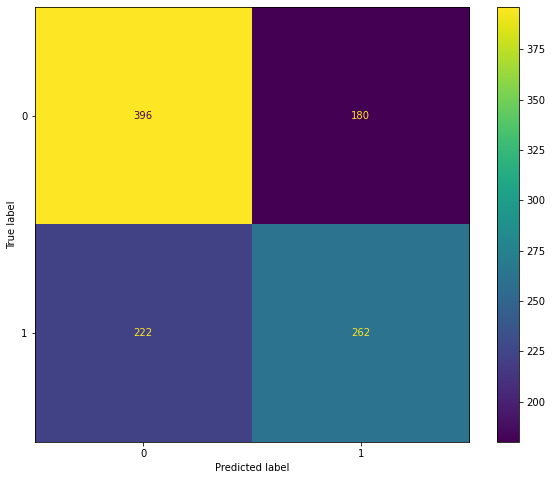

In [57]:
fig = plt.figure(figsize=(10, 8))
g = fig.add_subplot(1,1,1)
plot_confusion_matrix(xgboost_final, X_test, y_test, ax=g)

In [58]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

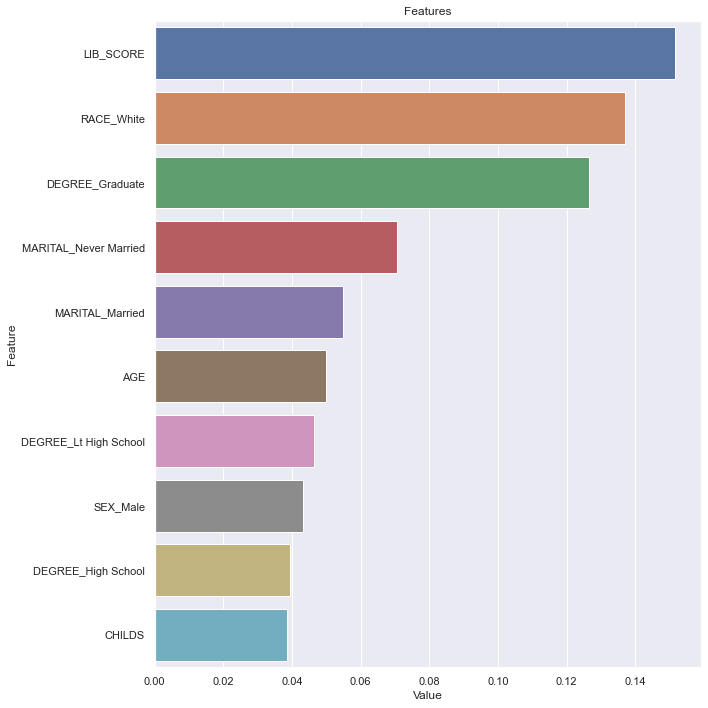

<Figure size 432x288 with 0 Axes>

In [59]:
plot_importance(xgboost_final, X, 10, True)